## *Purpose*

The purpose of this jupyter notebook is to retrieve **user information** from **Twitter** using the **GET /2/users
endpoint**. Important notes about the code and some helpful links can be found at the end of this notebook. By using this notebook one can understand the data retrieval process step by step. Otherwise, the .py script does the job, and just needs to be run in the command line or setting up a cronjob (if applicable).

## Import packages

In [1]:
import requests
import json
import time
import pandas as pd
import math

## Functions

Function to create endpoint URL:

- **user_IDs** need to be separated by commas without spaces and only up to 100

e.g. "6253282,783214"

- **fields** need to be separated by commas without spaces.
The possible fields are: *id*, *username*, *name*, *created_at*, *description*, *location*, *entities*, *public_metrics*, *url*, *verified*, *pinned_tweet_id*, *profile_image_url*, *protected* and *withheld*.

In [2]:
def create_url(user_IDs, fields):
    return "https://api.twitter.com/2/users?ids={}&user.fields={}".format(user_IDs, fields)

Function to create headers using the bearer token:

In [3]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

Sometimes when connecting to the endpoint there are errors. If the response code is 200, all is good. If the response yields a different status code then there was an error. I am printing these errors, but you can comment the print statements if you are not interested in knowing which type of error was yielded. When there is an error I make my program sleep between 5 and 60 seconds before trying again.

More about response codes [here].

[here]: https://developer.twitter.com/ja/docs/basics/response-codes

In [4]:
def connect_to_endpoint(url, headers):
    response = requests.request("GET", url, headers=headers)
    if response.status_code != 200:
        print(response.status_code)
        rn = random.randint(5,60)
        print('Sleeping '+str(rn)+' seconds...')
        time.sleep(rn)
        return connect_to_endpoint(url, headers)
    return response.json()

Function to save data in a json file:

In [5]:
def save_data(date, data, file_number):
    with open('./data/users_info_'+date+'_file'+str(file_number)+'.json','w', encoding='utf8') as tf:
        json.dump(data, tf, indent = 4, ensure_ascii = False)

## Setting up variables before retrieving data

Date of data retrieval:

*This might be important to take into consideration as the info you are retrieving about the users is the data at retrieval time. Hence it is subject to change.*

In [6]:
date = '2022_March_25'

Users information:

*The dataframe contains the IDs of the users we want to retrieve information from.*

For the purpose of this I chose IDs belonging to the following acounts:
- 6253282 => @twitterapi

- 783214 => @twitter

- 2244994945 => @twitterdev 
 
- 17874544 => @twittersupport

In [7]:
user_info = pd.read_pickle('author_IDs.pkl')

In [8]:
user_info

,author_id
0,6253282
1,783214
2,2244994945
3,17874544


I'm adding a comma at the end of each ID because then I can use the sum() function to get all IDs in one string separated by commas, as they need to be when using the URL for data retrieval.

In [9]:
user_info['author_id'] = user_info['author_id']+','

Twitter API credentials. You just need to replace the XXX by your bearer token.

In [10]:
bearer_token = "XXX"

Headers:

In [11]:
headers = create_headers(bearer_token)

Setting up user fields we want to have access to:

Remember that the possible fields are: *id*, *username*, *name*, *created_at*, *description*, *location*, *entities*, *public_metrics*, *url*, *verified*, *pinned_tweet_id*, *profile_image_url*, *protected* and *withheld*.

In [12]:
user_fields = 'id,username,name,created_at,description,location,public_metrics,url,verified'

## Retrieving data

The following code is prepared for the cases where **user_info** has more than 100 user IDs. If that's the case one will have  data saved to more than 1 file, each file with info of a maximum of 100 users.

When defining user IDs we apply sum() to get all IDs in one string separated by commas. With the example IDs above we get "6253282,783214,2244994945,17874544,". We then remove the last comma with the [:-1].

In [13]:
for i in range(math.ceil(len(user_info)/100)):
    if i != math.ceil(len(user_info)):
        user_IDs = user_info['author_id'][i*100:(i+1)*100].sum()[:-1]
    else:
        user_IDs = user_info['author_id'][i*100:].sum()[:-1]
    url = create_url(user_IDs, user_fields)
    
    json_response = connect_to_endpoint(url, headers)

    save_data(date, json_response, i)
    
    #sleep for 3.2 seconds not to surpass the rate limit
    time.sleep(3.2)

## Important notes about the above code and useful links:
- **Number of requests**: Each endpoint has its own limits. The GET /2/users endpoint allows you to do 300 requests per 15 minute time window which corresponds to 1 request every 3 seconds so I made my program sleep 3.2 seconds in between requests. You can have access to this information per endpoint signing in to your developer portal: https://developer.twitter.com/en/portal/products

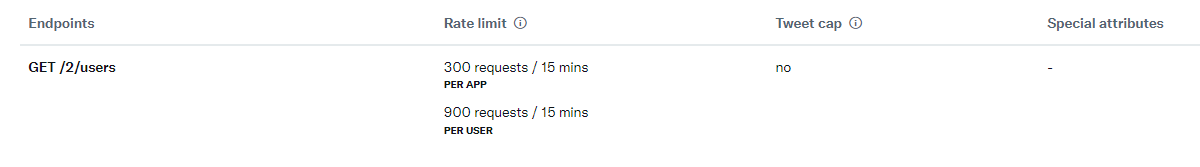

- **Possible response codes**: https://developer.twitter.com/ja/docs/basics/response-codes

- This code was inspired in Twitter's code that you can find here: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/User-Lookup/get_users_with_bearer_token.py
- Twitter community forum is a great place to ask questions, I have used it myself a couple of times and always find it useful: https://twittercommunity.com/
- Most information you will need to retrieve data from the the twitter API is scattered in https://developer.twitter.com/en/docs/twitter-api